[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alucantonio/data_enhanced_simulation/blob/master/8_Qlearning.ipynb)

# Deep Q-learning

Recall: state value given by the expectation $V_{\pi}(s) = \sum_i w_i R_i$, where $w_i$ are weights and
$R_i$ are rewards. In general, the weights should discount future rewards compared to
recent ones. Similarly, the action-value function $Q_\pi(s,a)$ takes a state and an
action as inputs and returns the value of taking that action given that state. A
Q function can be represented by a _Q-table_, a table where each cell corresponds to a state-action pair value.

Notice that when we have an optimal Q function, we have an optimal policy since we know
the best action to take at each state: $\pi(s) = \argmax_a Q(s,a)$.

The problem is that to calculate EACH value of a state or a state-action pair, we need
to sum all the rewards an agent can get if it starts at that state. The **Bellmann
Equation** simplifies the calculation of the value function ($\gamma$ is
the _discount factor_):

$$v_\pi(s_t) = \mathbb{E}_\pi[R_{t+1} + \gamma v_\pi(s_{t+1})]$$

**Q-learning**: algorithm that learns to predict the value of a
state-action pair (Q function); the prediction is compared to the observed accumulated rewards at
some later time to update the parameters of the algorithm. 

Based on the Bellmann equation, Q-learning algorithms use the update rule ($\alpha$ is
the _learning rate_)

$$Q(s_t,a_t) = Q(s_t,a_t) + \alpha[R_{t+1}+ \gamma \max Q(s_{t+1},a)-Q(s_t,a_t)] $$

i.e., the $Q$ value at time $t$ is updated to be the current predicted $Q$ value plus the
(discounted) amount of value we expect in the future (state $s_{t+1}$), given that we
play optimally from our current state. Here, $R_{t+1}$ is the observed reward
corresponding to the action $a_t$.

<figure>
    <img src="Qlearning_algo.png" alt="Caption" width="800" />
    <figcaption>Q-learning algorithm (taken from huggingface.co).</figcaption>
</figure>

## Solving the Gridworld environment with Q-learning

_Gridworld_ is a game where the player moves on a square board (or grid). The player has
to reach the goal (+), avoiding the wall (W) and the pit (-). Every nonwinning move
receives -1 as a reward. The winning move (reaching the goal) receives a +10, while
there is a -10 reward for losing the game (landing on the pit).

In [27]:
from Gridworld import Gridworld
import numpy as np
import jax.numpy as jnp
import random
from matplotlib import pylab as plt
from flax import nnx
import optax
# static = start from predetermined configuration (for player and objects)
# player = just the player is initialized at random location
# random = both player and objects are randomly placed
game = Gridworld(size=4, mode='static')

In [ ]:
# display current state
game.display()

In [ ]:
# example moves
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

In [ ]:
game.reward()

In [ ]:
# representation of the state as a 4x4x4 tensor
game.board.render_np()

In [6]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

We build a neural network as a Q function. More precisely, the network represents a
vector-valued Q function that accepts a state and returns a _vector_ of state-action
values, one for each possible action. 

In [7]:
class Model(nnx.Module):
  def __init__(self, l1, l2, l3, l4, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(l1, l2, rngs=rngs)
    self.linear2 = nnx.Linear(l2, l3, rngs=rngs)
    self.linear3 = nnx.Linear(l3, l4, rngs=rngs)

  def __call__(self, x):
    y = nnx.relu(self.linear1(x))
    y = nnx.relu(self.linear2(y))
    y = self.linear3(y)
    return y

l1 = 64 # input: state as a 1x64 vector
l2 = 150
l3 = 100
l4 = 4 # outputs

learning_rate = 1e-3
model = Model(l1, l2, l3, l4, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))
loss_fn = optax.losses.squared_error

In [8]:
gamma = 0.9
epsilon = 1.0

def _train_epoch(model, optimizer, state, game):
    def loss(model, state):
        qval = model(state)
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = int(np.argmax(qval))
        
        action = action_set[action_]
        game.makeMove(action)
        state2 = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        reward = game.reward()
        newQ = model(state2.reshape(1,64))
        maxQ = np.max(newQ)
        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = jnp.asarray([Y])
        X = jnp.array([qval.squeeze()[action_]])
        return optax.losses.squared_error(X, Y).mean(), (reward, state2)

    loss_and_aux, grads = nnx.value_and_grad(loss, has_aux=True)(model, state)
    optimizer.update(grads)
    loss, aux = loss_and_aux
    reward, state2 = aux

    return loss, reward, state2

Run the main training loop.

In [9]:
games = 1000
losses = []
for i in range(games):
    game = Gridworld(size=4, mode='static')
    # add some noise to the initial state (because most of the state elements are 0,
    # potential problem with ReLU activations)
    state1 = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    status = 1
    while(status == 1):
        loss, reward, state1 = _train_epoch(model, optimizer, state1, game)
        losses.append(loss.item())
        if reward != -1:
            status = 0
    if epsilon > 0.1:
        epsilon -= (1/games)

In [ ]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
# Helper function to play games with trained models

def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1):
        qval = model(state)
        action_ = int(np.argmax(qval))
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [ ]:
test_model(model, 'static')

In [ ]:
test_model(model, 'random')

### Introducing experience replay

We can use **experience replay** to counter _catastrophic forgetting_ (i.e. similar
games with very different outcomes, leading to inability to properly learn anything).
Here is the algorithm:
1. In state $s$ take action $a$ and observe the new state $s_{t+1}$ and reward $r_{t+1}$.
2. Store the tuple $(s, a, s_{t+1}, r_{t+1})$ in the replay buffer.
3. Continue to store each experience in the buffer until you have filled it to a
   specific length.
4. Once the experience replay memory is filled, randomly select a batch (with a given
   batch size).
5. Calculate updates of the $Q$ value for each element of the batch and store them in a
   target array ($Y$).
6. Use the Q-value predicted by the network for each state-action in the batch and the
   updates $Y$ for training (updating the parameters of the network). For subsequent
   moves where the replay memory is full, overwrite old values.

Use the following class to implement Q-learning with experience replay.

In [28]:
import random
from collections import deque
import numpy as np

class ReplayBuffer:
    def __init__(self, max_size):
        # a deque is a list with a maximum size, so that if you try to append something
        # when it is already full, it will overwrite the first item in the list
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))

    def size(self):
        return len(self.buffer)

In [29]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [30]:
#@title: Solution:

class Model(nnx.Module):
  def __init__(self, l1, l2, l3, l4, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(l1, l2, rngs=rngs)
    self.linear2 = nnx.Linear(l2, l3, rngs=rngs)
    self.linear3 = nnx.Linear(l3, l4, rngs=rngs)

  def __call__(self, x):
    y = nnx.relu(self.linear1(x))
    y = nnx.relu(self.linear2(y))
    y = self.linear3(y)
    return y

l1 = 64
l2 = 150
l3 = 100
l4 = 4

learning_rate = 1e-3
model = Model(l1, l2, l3, l4, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))

In [31]:
replay_buffer_size = 1000
batch_size = 200
games = 5000 
epsilon = 0.3
gamma = 0.9
losses = []
total_rewards = []
max_moves = 50

In [41]:
#@title: Solution:

@nnx.jit
def loss_fn(model, states, q_updates, actions):
    q_values = model(states)
    q_value = jnp.take_along_axis(q_values, actions[:, None, None], axis=2)[:,:,0]
    loss = optax.losses.squared_error(q_value, q_updates).mean()
    return loss

@nnx.jit
def q_learning_update(model, states, actions, rewards, next_states, dones, optimizer):
    target_q_values = model(next_states)
    max_target_q_values = jnp.max(target_q_values, axis=2)

    q_updates = rewards.reshape(-1,1) + gamma * max_target_q_values * (1 - dones.reshape(-1,1))

    loss, gradients = nnx.value_and_grad(loss_fn)(model, states, q_updates, actions)
    optimizer.update(gradients)
    
    return loss

In [42]:
#@title Solution:

def train():
    replay_buffer = ReplayBuffer(replay_buffer_size)

    for i in range(games):
        game = Gridworld(size=4, mode='random')
        state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        mov = 0
        done = False
        total_reward = 0

        while not done:
            mov += 1
            if (random.random() < epsilon):
                action_ = np.random.randint(0,4)
            else:
                qval = model(state)
                action_ = int(np.argmax(qval))
            
            action = action_set[action_]
            game.makeMove(action)
            next_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
            reward = game.reward()
            done = True if reward > 0 else False

            replay_buffer.add((state, action_, reward, next_state, done))

            if replay_buffer.size() >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = batch
                loss = q_learning_update(model, states, actions, rewards, next_states, dones, optimizer)
                losses.append(loss)

            state = next_state
            total_reward += reward

            if reward != -1 or mov > max_moves:
                done = True

        total_rewards.append(total_reward)

        if i%100 == 0:
            print(f"Game: {i}, Total Reward: {total_reward}")

In [43]:
train()

Game: 0, Total Reward: 6
Game: 100, Total Reward: 3
Game: 200, Total Reward: 10
Game: 300, Total Reward: 9
Game: 400, Total Reward: 10
Game: 500, Total Reward: -1
Game: 600, Total Reward: 8
Game: 700, Total Reward: -2
Game: 800, Total Reward: -14
Game: 900, Total Reward: 3
Game: 1000, Total Reward: -2
Game: 1100, Total Reward: 7
Game: 1200, Total Reward: 8
Game: 1300, Total Reward: 7
Game: 1400, Total Reward: 8
Game: 1500, Total Reward: -10
Game: 1600, Total Reward: 7
Game: 1700, Total Reward: 4
Game: 1800, Total Reward: 10
Game: 1900, Total Reward: 7
Game: 2000, Total Reward: 9
Game: 2100, Total Reward: 7
Game: 2200, Total Reward: 0
Game: 2300, Total Reward: 7
Game: 2400, Total Reward: 9
Game: 2500, Total Reward: -28
Game: 2600, Total Reward: 4
Game: 2700, Total Reward: 1
Game: 2800, Total Reward: 9
Game: 2900, Total Reward: -12
Game: 3000, Total Reward: 9
Game: 3100, Total Reward: 10
Game: 3200, Total Reward: 10
Game: 3300, Total Reward: 7
Game: 3400, Total Reward: -40
Game: 3500, To

In [44]:
losses = np.array(losses)
total_rewards = np.array(total_rewards)

Plot the training loss and total reward as a function of the number of episodes (games).
Use the `running_mean` helper function to make the reward plot smoother.

In [45]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y


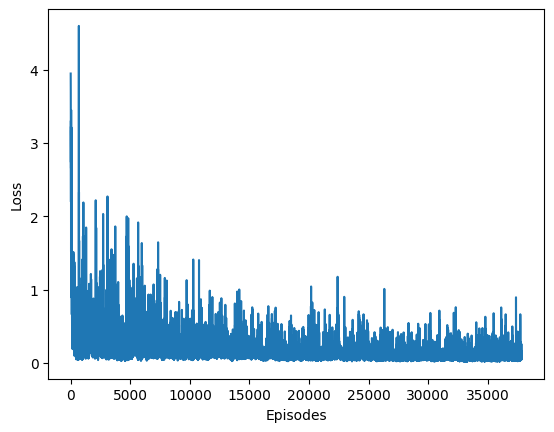

In [46]:
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()

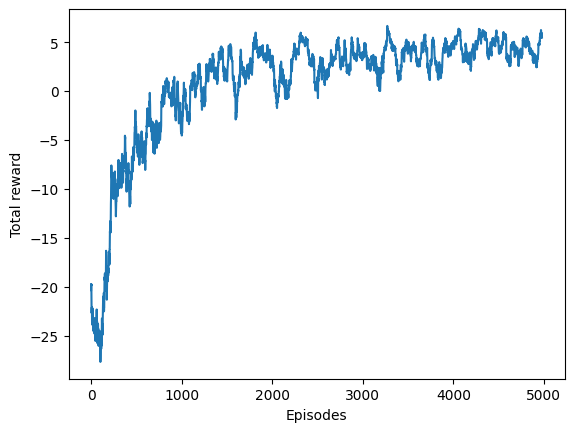

In [47]:
plt.plot(running_mean(total_rewards))
plt.xlabel("Episodes")
plt.ylabel("Total reward")
plt.show()

Test the model with a random initial condition using the `test_model` helper function.

In [48]:
test_model(model, mode='random')

Initial State:
[[' ' ' ' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 0; Taking action: r
[[' ' ' ' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 1; Taking action: r
[[' ' ' ' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 2; Taking action: r
[[' ' ' ' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 3; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' '-' ' ' ' ']
 [' ' ' ' '+' ' ']]
Move #: 4; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '-' ' ' ' ']
 ['P' ' ' '+' ' ']]
Move #: 5; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' 'P' '+' ' ']]
Move #: 6; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' '+' ' ']]
Game won! Reward: 10


True

Evaluate the percentage of won games out of 1000 using the trained model.

In [49]:
#@title Solution:

max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 902
Win percentage: 90.2%


Extensions:

- Grid size: increase the grid size to make the task more challenging.
- Action space: extend the action space (e.g., diagonal moves).
- Multiple obstacles: add more obstacles to the environment.